In [3]:
import ROOT
import os
import numpy as np
%run ../src/plotting_toolkit.py

Welcome to JupyROOT 6.22/06


In [4]:
PROJECT_NAME = "test4"
PROJECT_PATH = "/volatile/clas12/users/gmat/solid.data/coherent_deuteron_threshold/projects/"
TARGET_TYPE  = "d"
PLOT_DIR = f"./plots/{PROJECT_NAME}/detected_events"
PLOT_DIR_PNG = f"{PLOT_DIR}/png"
PLOT_DIR_PDF = f"{PLOT_DIR}/pdf"
try:
    os.makedirs(PLOT_DIR)
    os.makedirs(PLOT_DIR_PNG)
    os.makedirs(PLOT_DIR_PDF)
    print(f"Created directory: {PLOT_DIR}")
except:
    pass

In [5]:
bh_tree, photo_tree, electro_tree = get_tchains(PROJECT_NAME,PROJECT_PATH,"acc")

beam_energy, integrated_luminosity, bh_events, days = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"bh")
_, _, photo_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"photoproduction")
_, _, electro_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"electroproduction")

luminosity = get_lumi_from_integrated(integrated_luminosity,TARGET_TYPE,days)

In [6]:
evtgen_dict = {
    "bh" : {
        "name" : "Bethe-Heitler",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*psf*flux*{integrated_luminosity/bh_events}",
        "ttree": bh_tree,
    },
    "photo" : {
        "name" : "J/#Psi Photoproduction",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*psf*flux*decay_weight*{integrated_luminosity/photo_events}",
        "ttree": photo_tree
    },
    "electro" : {
        "name" : "J/#Psi Electroproduction",
        "tcut" : f"acc_ePlus*acc_eMinus*acc_hOut*weight*psf*flux*decay_weight*{integrated_luminosity/electro_events}",
        "ttree": electro_tree
    }
}


plot_dict = {
    "Q2" : {
        "xtitle" : "Q^{2} [GeV^{2}]",
        "branch" : "smear_q.M2()" ,
        "hist"   : ROOT.TH1F("hist","",100,-1,1),
    },
    "t" : {
        "xtitle" : "-t [GeV^{2}]",
        "branch" : "-smear_t" ,
        "hist"   : ROOT.TH1F("hist","",100,0,3)
    },
    "gammaE" : {
        "xtitle" : "E_{#gamma} [GeV]",
        "branch" : "smear_q.E()" ,
        "hist"   : ROOT.TH1F("hist","",100,5.5,9)
    },
    "VM" : {
        "xtitle" : "M_{e^{+}e^{-}} [GeV]",
        "branch" : "smear_VM.M()" ,
        "hist"   : ROOT.TH1F("hist","",100,2.4,3.8)
    }
}

cut_dict = {
    "none" : {
        "tcut" : "",
        "cutstrings" : []
    },
    "Q2only" : {
        "tcut" : "(abs(smear_q.M2())<0.02)",
        "cutstrings" : ["|Q^{2}| < 0.02 GeV^{2}"]
    },
    "ana" : {
        "tcut" : "(abs(smear_q.M2())<0.02 && smear_VM.M()>3&&smear_VM.M()<3.2)",
        "cutstrings" : ["|Q^{2}| < 0.02 GeV^{2}", "3.0 < M_{ee} < 3.2 GeV"]
    }
}

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


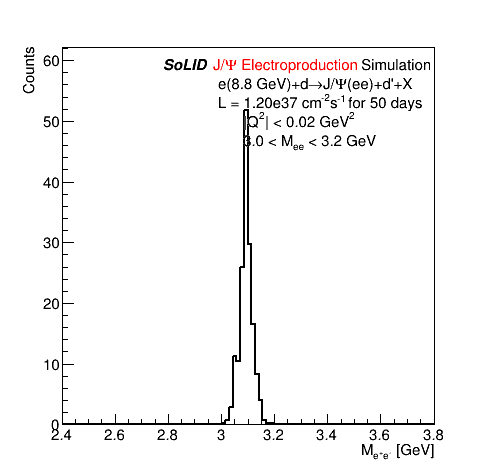

In [7]:
plot_number = 20000
ROOT.gErrorIgnoreLevel = ROOT.kError
for plot, plot_values in plot_dict.items():
    for evtgen, evtgen_values in evtgen_dict.items():
        for cut, cut_values in cut_dict.items():

            c = ROOT.TCanvas("c","c",500,500)
            ROOT.gStyle.SetOptStat(0)
            ROOT.gPad.SetRightMargin(0.125)
            ROOT.gPad.SetLeftMargin(0.125)
            tree = evtgen_values["ttree"]
            h    = plot_values["hist"].Clone()
            h.SetLineColor(1)
            h.SetLineWidth(2)
            h.SetName(f"hist_{plot_number}")
            weight_str = evtgen_values['tcut']
            if cut_values['tcut']:
                weight_str+="*"+cut_values['tcut']
            draw_str = f"{plot_values['branch']}>>hist_{plot_number}"
            h_title = f";{plot_values['xtitle']};Counts"
            option_str = "hist"

            tree.Draw(draw_str, weight_str, "goff")
            h.SetTitle(h_title)
            h.Draw(option_str)
            h.GetYaxis().SetRangeUser(0,h.GetMaximum()*1.2)

            dy = 0.04
            x1 = 0.33 if evtgen!="bh" else 0.4
            x2 = 0.44
            y  = 0.85 
            latex = ROOT.TLatex()
            latex.SetTextSize(dy-0.005)
            latex.SetTextFont(42)
            latex.DrawLatexNDC(x1,y,"#bf{#it{SoLID}} #color[2]{"+evtgen_values["name"]+"} Simulation")
            latex.DrawLatexNDC(x2,y-dy,f"e({beam_energy} GeV)+d#rightarrow"+("J/#Psi(ee)" if evtgen!="bh" else "(e^{+}+e^{-})") + "+d'+X")
            latex.DrawLatexNDC(x2,y-2*dy,f"L = {luminosity} cm^{{-2}}s^{{-1}} for {days:0.0f} days")
            for i in range(len(cut_values['cutstrings'])):
                latex.DrawLatexNDC(x2+0.05,y-(3+i)*dy,cut_values['cutstrings'][i])
            plot_name = f"{evtgen}_{plot}"
            c.SaveAs(f"{PLOT_DIR_PNG}/{plot_name}.cut_{cut}.png")
            c.SaveAs(f"{PLOT_DIR_PDF}/{plot_name}.cut_{cut}.pdf")
            c.Draw()
            plot_number+=1


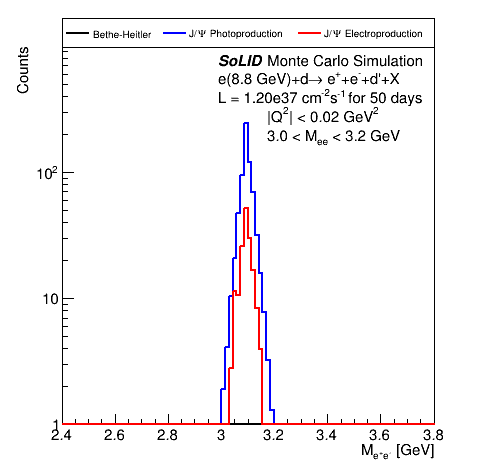

In [8]:
plot_number = 0 
ROOT.gErrorIgnoreLevel = ROOT.kError
for cut, cut_values in cut_dict.items():
    for plot, plot_values in plot_dict.items():
        c = ROOT.TCanvas("c","c",500,500)
        H=[]
        legend=ROOT.TLegend(0.125,0.9,0.875,0.96)
        legend.SetNColumns(3)

        for evtgen, evtgen_values in evtgen_dict.items():

            ROOT.gPad.SetLogy()
            ROOT.gStyle.SetOptStat(0)
            ROOT.gPad.SetRightMargin(0.125)
            ROOT.gPad.SetLeftMargin(0.125)
            tree = evtgen_values["ttree"]
            h    = plot_values["hist"].Clone()
            h.SetLineColor(1)
            h.SetLineWidth(2)
            h.SetName(f"hist_{plot_number}")
            weight_str = evtgen_values['tcut']
            if cut_values['tcut']:
                weight_str+="*"+cut_values['tcut']
            draw_str = f"{plot_values['branch']}>>hist_{plot_number}"
            h_title = f";{plot_values['xtitle']};Counts"
            option_str = "hist"

            tree.Draw(draw_str, weight_str, "goff")
            h.SetTitle(h_title)
            if evtgen=="bh":
                h.SetLineColor(1)
            elif evtgen=="photo":
                h.SetLineColor(4)
            else:
                h.SetLineColor(2)


            H.append(h)
            H[-1].Draw(option_str + " same")
            legend.AddEntry(H[-1],evtgen_values["name"],"l")
            plot_number+=1

        ymax = H[-1].GetMaximum()
        for h in H:
            ymax0 = h.GetMaximum()
            if ymax0>ymax:
                ymax=ymax0

        H[0].GetYaxis().SetRangeUser(1,ymax*4)
        dy = 0.04
        x1 = 0.44
        x2 = 0.44
        y  = 0.86 
        latex = ROOT.TLatex()
        latex.SetTextSize(dy-0.005)
        latex.SetTextFont(42)
        latex.DrawLatexNDC(x1,y,"#bf{#it{SoLID}} Monte Carlo Simulation")
        latex.DrawLatexNDC(x2,y-dy,f"e({beam_energy} GeV)+d#rightarrow e^{{+}}+e^{{-}}+{TARGET_TYPE}'+X")
        latex.DrawLatexNDC(x2,y-2*dy,f"L = {luminosity} cm^{{-2}}s^{{-1}} for {days:0.0f} days")
        for i in range(len(cut_values['cutstrings'])):
            latex.DrawLatexNDC(x2+0.1,y-(3+i)*dy,cut_values['cutstrings'][i])
        legend.Draw("same")
        plot_name = f"{plot}"
        c.SaveAs(f"{PLOT_DIR_PNG}/all.{plot_name}.cut_{cut}.png")
        c.SaveAs(f"{PLOT_DIR_PDF}/all.{plot_name}.cut_{cut}.pdf")
        c.Draw()
    
            